# Wiktor Ciołek 311501 SATFD laboratory 2 23.03.2024

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.signal.windows as wd
from scipy.io import wavfile
from scipy.signal import chirp, hilbert, spectrogram
from cohen import *

plt.rcParams['font.size'] = 18

# 1. Introduction
In this exercise, theory of measuring time-changing frequency is explored, tested and presented. Chirp signal is utilized for this task throughout the whole lab. It's a signal, where frequency of a sine wave is changing linearly in time. At a given time, the instantanous frequency is given:
$$f(t) = f_1 + (f_2 - f_1) \frac{t}{t_1}$$
, where $t_1$ is a period of the changing frequency.
Particular attention is paid to the following elements of signal analysis theory:
1. **STFT - Short Time Fourier Transform** The output signal of the STFT transform is a sum of FFT performed with each-step-shifting window. Most importantly, the shorter the window the better is the time resolution of the output signal. Conversely, the longer the window, the better is the frequency resolution. Such problem is addressed by the following point.
2. **Measurment Uncertainty** The law of finite measurment precision states that one cannot measure both time and frequency with infinite resolution. Precisely, standard deviation of both measurments is given by following inequality: $$\Delta_x\Delta_\omega \geq \frac{1}{2}$$ It can be proven, that equlity is possible only for gaussian window.
3. **Wigner-Ville Transform** W-G transform is similar in results to STFT method. Being a member of Cohen Transform's class it takes anlytical signal as input. Analytical signal is a complex function and is defined as following: $$X_a(t) = X(t) + i\cdot H[X(t)]$$, where H(X) is Hilbert Transform
4. **Hilbert Transform** Hilbert Transform is defined as convolution of a signal with $\frac{1}{\pi t}$. It is to be taken as imaginary part of a analytical signal.  


# 2. Chirp signal generation
First, a chirp signal is generated with help of *scipy.signal* library. Setting the parameter $t_1$ to `T[-1]` ensures that the frequency is ever increasing. Of particular importance are those three parameters:
* `N` - length of the signal
* `f1, f2` - start and end frequencies
* `fs` - sampling frequency. This is the highest resolvable frequency in the signal 

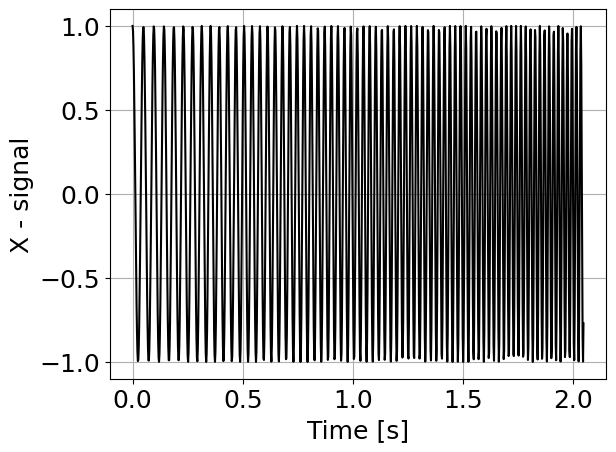

In [116]:
N = 2**10
f1, f2 = 20, 50
fs = 500

T = np.arange(N) / fs
X = chirp(T, f1, T[-1], f2)
plt.plot(T, X, 'k-')
plt.xlabel("Time [s]")
plt.ylabel("X - signal")
plt.grid()

# 3. Uncertainty Principiple visualization
Given the signal `X`, in the cell below, STFT is performed and visualized as a 3D plot color mesh. There, the brighter the color, the greater the magnitude of the signal in frequency domain. Several images are drawn, each corresponding to different STFT. Those STFT transforms differ, by one parameter - window length a.k.a `nperseg`. Additionally, `nfft` parameter indicating the length of FFT transform is changed and correlated with window length. The Uncertainty principle should be observed in the width of blurs. Starting from the first image, corresponding to a very short window, each blur is well located in time domain. One can tell the postion in time pretty accurately. On the other hand, the frequency at that given point in time is almost fully uncertain as the blur spans at many frequencies. This is changing consequently with the lengthening of the window. Finally, the last image allows to tell the frequencies at each FFT very accurately. However, wide time window makes this signal poorly located in time domain. 
The time resolution can be given by the standard deviation of the moving time window. Frequency resolution is, on the other hand, the smallest frequency differency obtain from the transform.

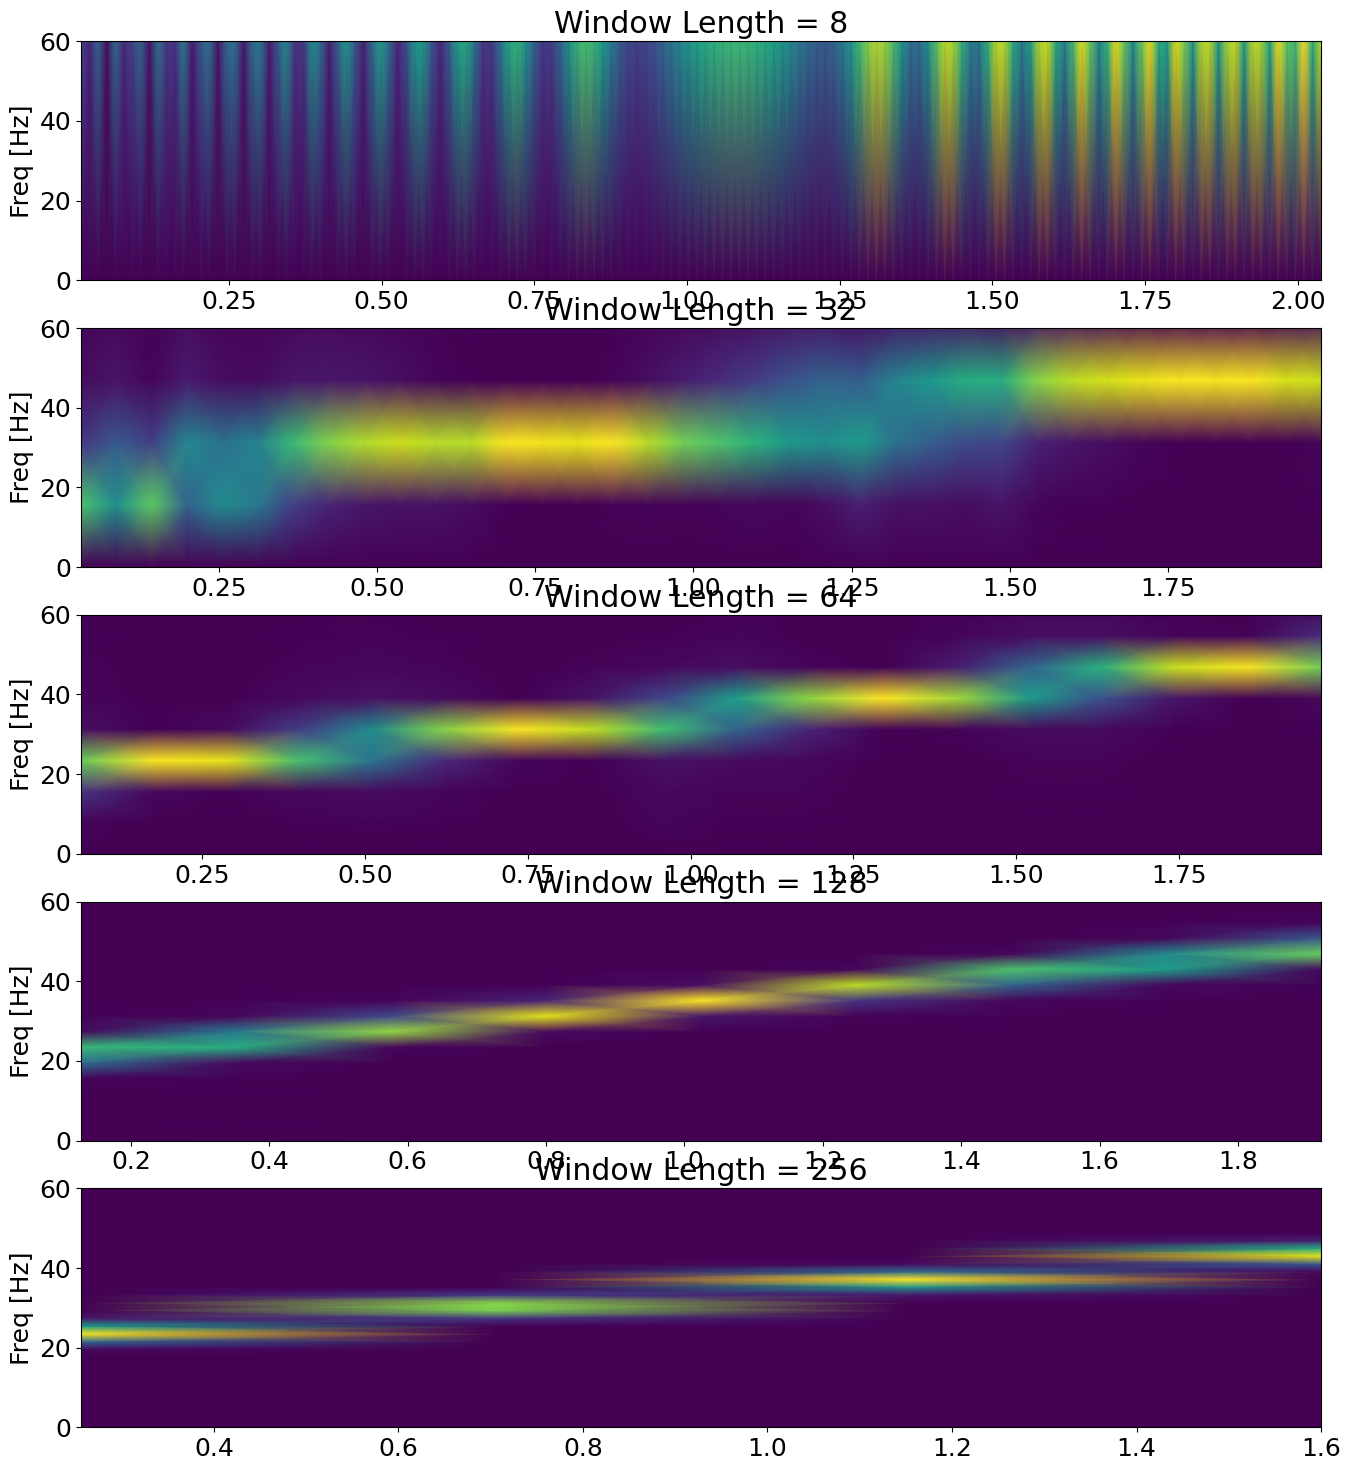

In [117]:
std=50
M = [2**4, 2**6, 2**7, 2**8, 2**9]
fig, ax = plt.subplots(nrows=len(M), figsize=(16, 18))

for i, m in enumerate(M):
    wd_len = m // 2
    window = wd.gaussian(M=wd_len, std=std)
    f, t, Sxx = spectrogram(X, fs, window=window, nfft=wd_len)
    ax[i].pcolormesh(t, f, Sxx, shading='gouraud')
    ax[i].set_title(f"Window Length = {m//2}")

for a in ax:
    a.set_ylabel("Freq [Hz]")
    a.set_ylim(0, 60)

# 4. Wigner-Ville Transform
In the cell below, the Wigner-Ville Transform is performed on the the same chirp signal. First, analytical signal is performed by performing *scipy.signal.hilbert* transformation. Obtained signal can be imputed into the funtion from ***cohen.py*** file ([path on local device](/cohen.py)). Both absolute value and logarithm of absolute value are 3D plotted. The absolute value is taken as the transform outputs a complex array. Wigner-Ville Transform gives similar results as STFT method. One could even say that it results in better time and frequency resolution. However, there are costs to that such as artifact generation, which can be observed as noise lines at the color mesh. 

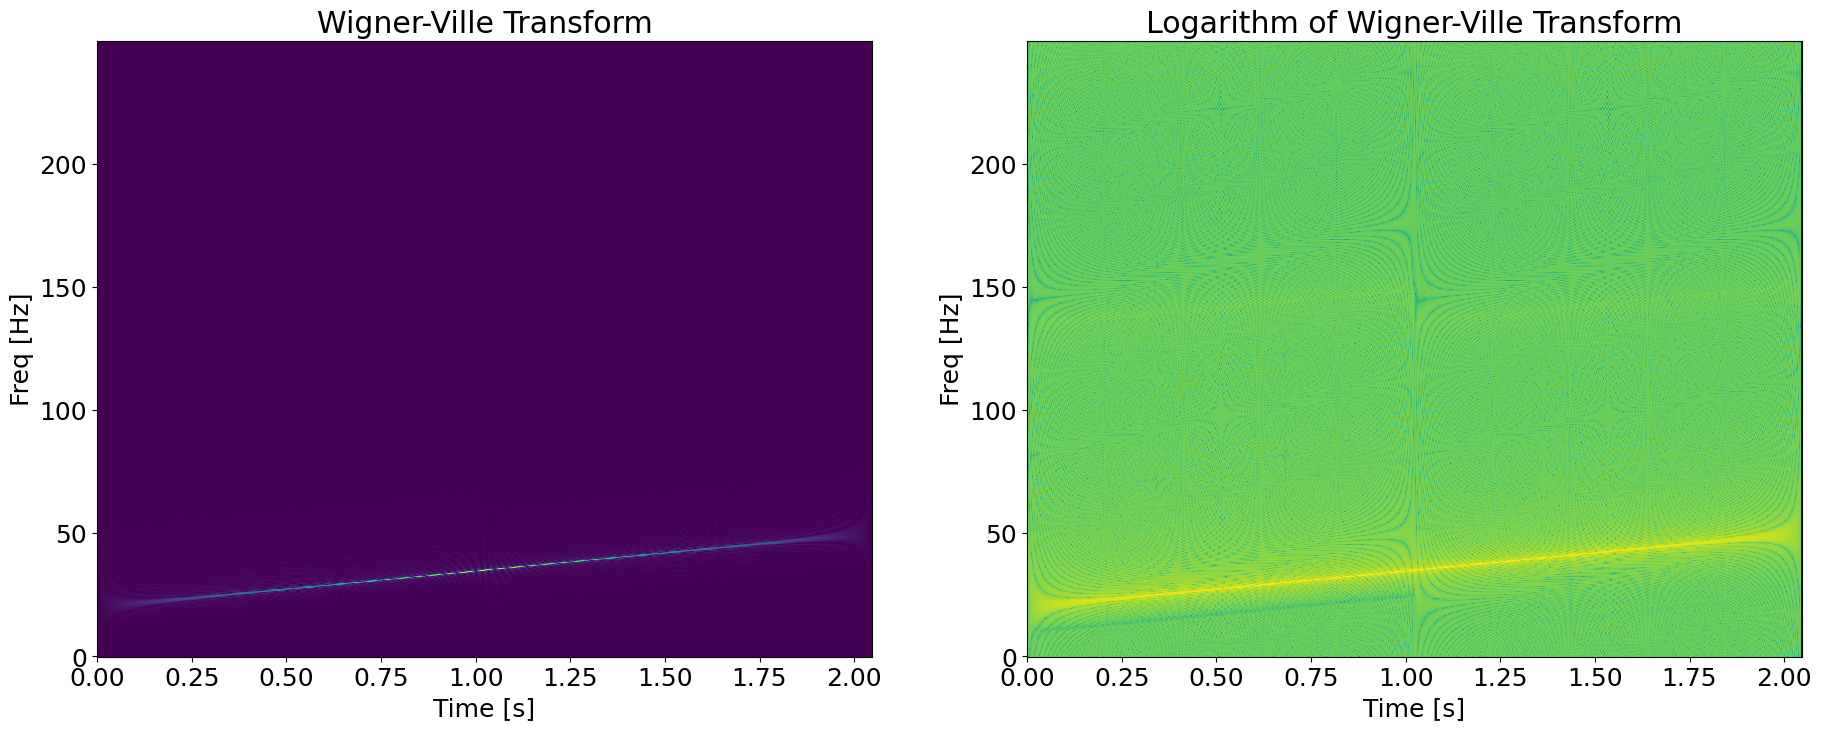

In [118]:
X_a = hilbert(X)
WV, f, t = cohen(X_a, fs)

fig, ax = plt.subplots(ncols=2, figsize=(22, 8))

ax[0].set_title("Wigner-Ville Transform")
ax[0].pcolormesh(t, f, np.abs(WV))
ax[1].set_title("Logarithm of Wigner-Ville Transform")
ax[1].pcolormesh(t, f, np.log10(np.abs(WV)+1e-9))

for x in ax:
    x.set_ylabel("Freq [Hz]")
    x.set_xlabel("Time [s]")

# 5. W-V and STFT comparison
In this section, Wigner-Ville transform is compared side by side with STFT. Fixed window length is chosen as well as signal length and sampling frequency. The section is divided into three parts:
1. First, different final freqencies are displayed for the chirp signal. A question might be raised after a first look at the plots - why are there double frequencies despite the ever rising frequency of the chirp signal. The answer can be given using Nyquist sampling theoerm and Discrete Fourier Transform definition. As per Nyquist greatest observable frequency in the signal is 2 times smaller than the sampling frequency. Secondly DFT is performed only for N/2 to points. That's why the straight line 'bounces' from the upper frequency limit. Simply put - higher frequencies are obesrved as proportionally lower ones. In this subsection, the artifact defects of W-V transform are visible. Once the frequencies higher than `fs / 2` appear the artifacts also appear. Such artifacts are not present in the spectrogram image. On the other hand, the resolution of the blurs gets lower there with greater final frequency.
2. Secondly, parallel chirp signals are observed. W-V transofrm as well as STFT is prone to not detect those two as separable signals. W-V is additionally creating a third in-between frequency. Such problem may addressed by balancing `nfft` parameter of STFT or by shortening the window.
3. Thirdly, non-parallel sum of shirps is taken into account. W-V output is rather noisy there, but 2 seperate lines can be observed. With spectrogram method, both signals are visible as separate ones. There is one point at which signals interfere resulting in high magnitude output. One should learn from there, that though at no point in time there are 2 same frequencies, the STFT method mistakes them as a stronger presence. Naturally, this wouldn't be the case if the sampling frequency was high enough.

In [119]:
wd_len = 2**6
window = wd.hamming(wd_len)
N = 2**9
fs = 500
T = np.arange(N) / fs

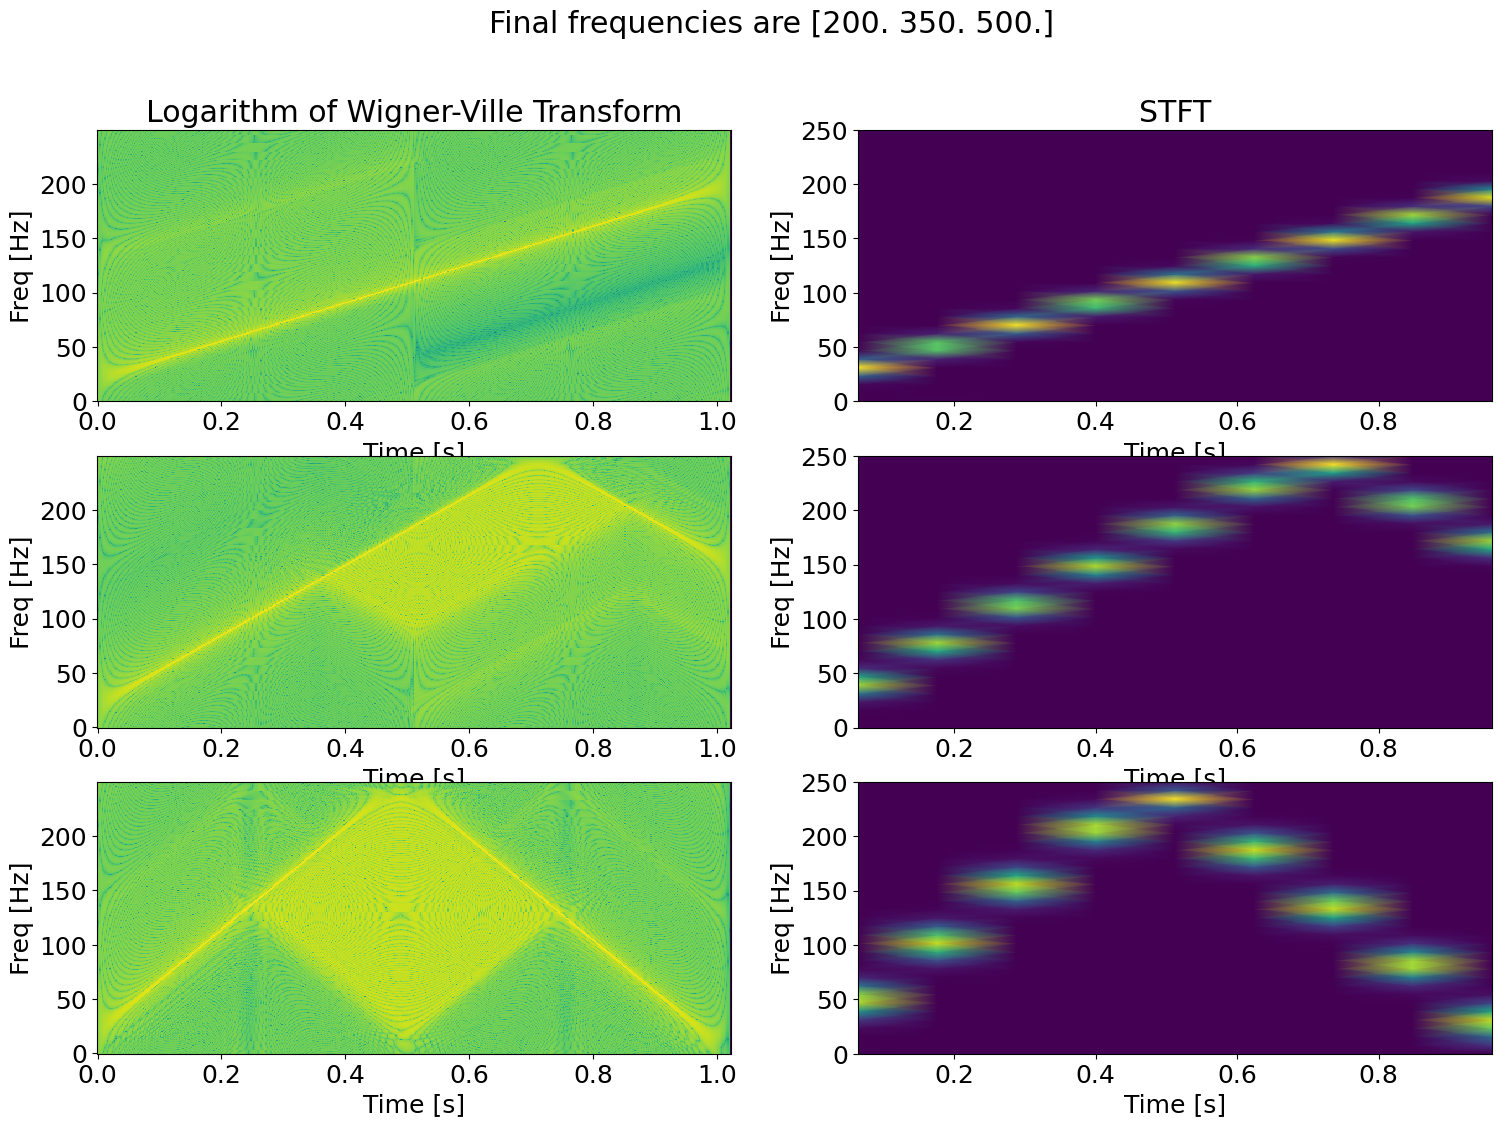

In [120]:
####### a) #######
final_freqs = np.linspace(200, 500, 3)
fig, ax = plt.subplots(ncols=2, nrows=len(final_freqs), figsize=(18, 12))
fig.suptitle(f"Final frequencies are {final_freqs}")

for i, f2 in enumerate(final_freqs):
    X = chirp(T, f1, T[-1], f2)

    X_a = hilbert(X)
    WV, f, t = cohen(X_a, fs)

    if i == 0:
        ax[i,0].set_title("Logarithm of Wigner-Ville Transform")
    ax[i,0].pcolormesh(t, f, np.log10(np.abs(WV)+1e-9))

    f, t, Sxx = spectrogram(X, fs, window=window)

    ax[i,1].pcolormesh(t, f, Sxx, shading='gouraud')
    if i == 0:
        ax[i,1].set_title("STFT")

for x in ax.flatten():
    x.set_ylabel("Freq [Hz]")
    x.set_xlabel("Time [s]")

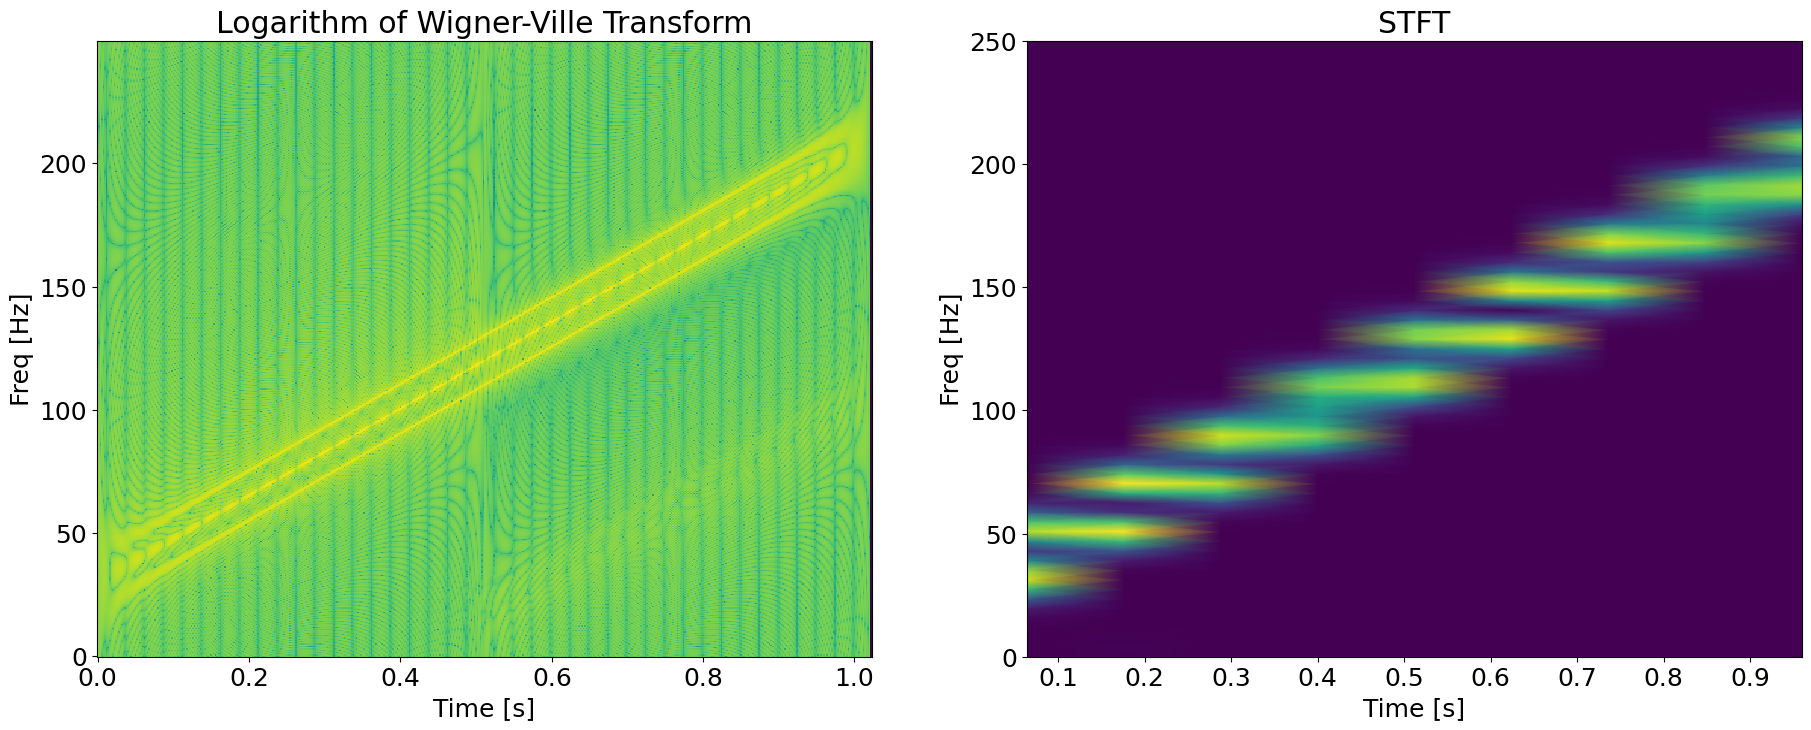

In [121]:
####### b) #######
fig, ax = plt.subplots(ncols=2, figsize=(22, 8))

f1 = 20
f2 = 200
f1_prim = 2 * f1
f2_prim = f1 + f2
X1 = chirp(T, f1, T[-1], f2)
X2 = chirp(T, f1_prim, T[-1], f2_prim)
X = X1 + X2

# plt.plot(T, X)
X_a = hilbert(X)
WV, f, t = cohen(X_a, fs)

ax[0].set_title("Logarithm of Wigner-Ville Transform")
ax[0].pcolormesh(t, f, np.log(np.abs(WV)+1e-9))


f, t, Sxx = spectrogram(X, fs, window=window, nfft=wd_len*2)


ax[1].pcolormesh(t, f, Sxx, shading='gouraud')
ax[1].set_title(f"STFT")

for x in ax:
    x.set_ylabel("Freq [Hz]")
    x.set_xlabel("Time [s]")

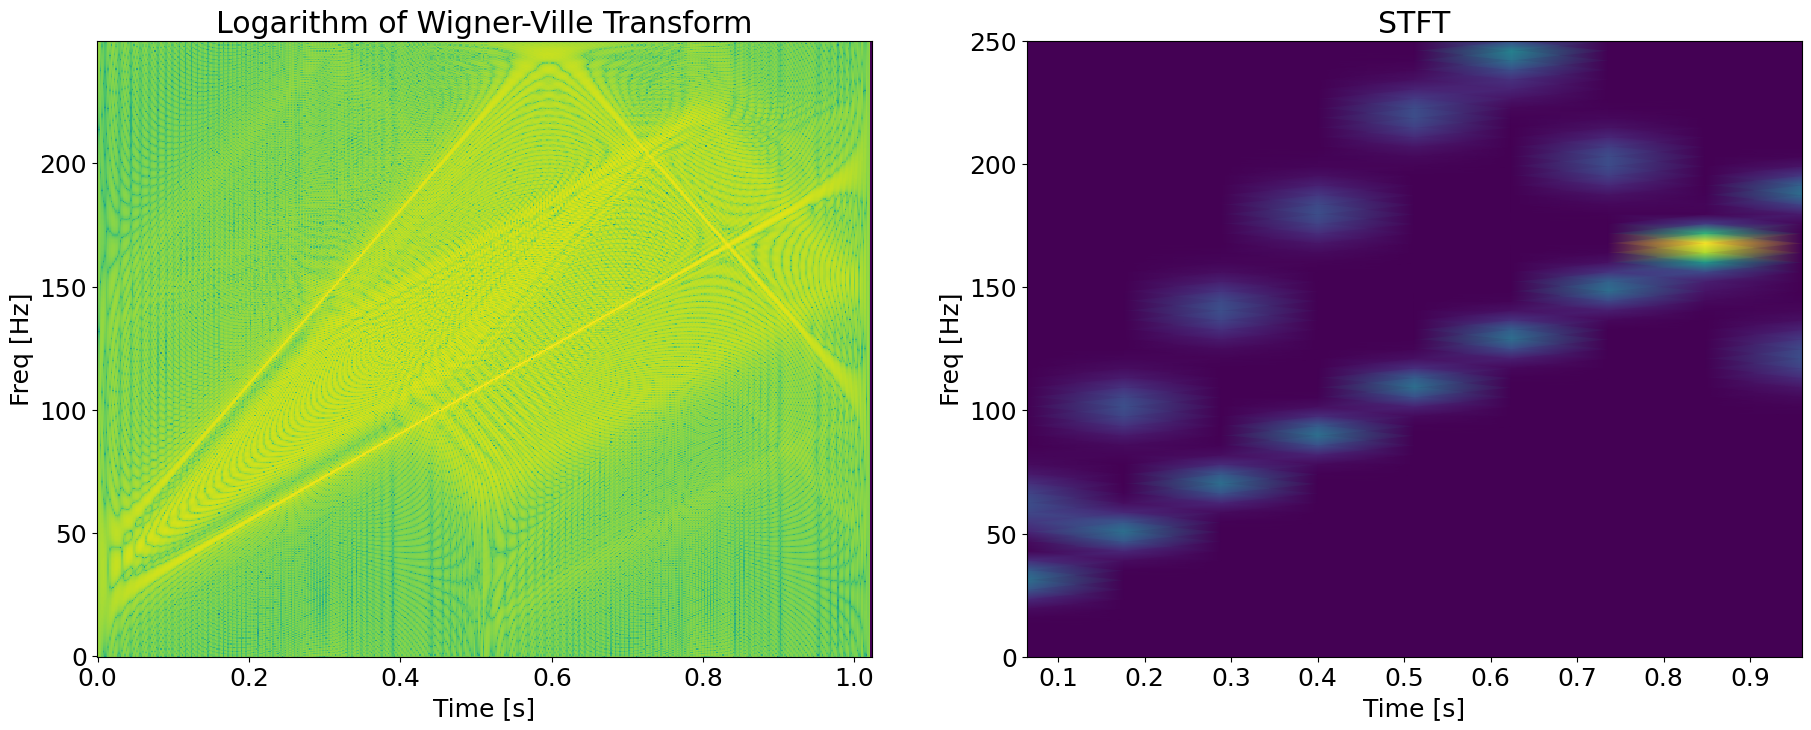

In [122]:
####### c) #######
fig, ax = plt.subplots(ncols=2, figsize=(22, 8))

f1 = 20
f2 = 200
f1_prim = 2 * f1
f2_prim = 2 * f2
X1 = chirp(T, f1, T[-1], f2)
X2 = chirp(T, f1_prim, T[-1], f2_prim)
X = X1 + X2

# plt.plot(T, X1)
X_a = hilbert(X)
WV, f, t = cohen(X_a, fs)

ax[0].set_title("Logarithm of Wigner-Ville Transform")
ax[0].pcolormesh(t, f, np.log(np.abs(WV)+1e-9))


f, t, Sxx = spectrogram(X, fs, window=window, nfft=2*wd_len)


ax[1].pcolormesh(t, f, Sxx, shading='gouraud')
ax[1].set_title(f"STFT")

for x in ax:
    x.set_ylabel("Freq [Hz]")
    x.set_xlabel("Time [s]")

# 6. Summary
All the aforementioned methods and theorems were tested and presented in this exercise. 